In [3]:
#Copyright 2019, Seokjun Bu, Softcomputing LAB all rights reserved.
%matplotlib inline
import pickle
import glob
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models import Model, load_model
from keras.utils import np_utils, multi_gpu_model
from keras.callbacks import EarlyStopping
from keras.layers import Input, Lambda, concatenate, TimeDistributed, CuDNNLSTM, BatchNormalization, LSTM
from keras.layers.core import Dense, Dropout, Flatten, Reshape
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

Using TensorFlow backend.


In [4]:
def plot_history(model_input, mode='loss', title='Entropy'):
    history = model_input.history
    plt.plot(history.history[mode])
    plt.plot(history.history['val_'+mode])
    plt.title(title)
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

In [5]:
with open ("data/hourly/df.pkl", "rb") as f:
    dataset = pickle.load(f)
print(dataset.shape)

(20923, 19)


In [6]:
dataset = dataset[dataset.bike_count != dataset.bike_count.max()]

### 데이터 전처리

In [7]:
dataset["cat_prec"] = dataset["Precipitation"].apply(lambda x : 0 if x == 0 else 1 if x < 3 else 2)
dataset["cat_snow"] = dataset["Snowfall"].apply(lambda x : 0 if x == 0 else 1 if x < 3 else 2)

In [14]:
columns_with_d = list(dataset.columns)
columns_with_d.remove('date')
columns_with_d.remove('timestamp')
columns_with_d.remove('NO2')
columns_with_d.remove('O3')
columns_with_d.remove('CO')
columns_with_d.remove('SO2')
columns_with_d.remove('Precipitation')
columns_with_d.remove('Snowfall')
print(columns_with_d)
columns = list(dataset.columns)
columns.remove('date')
columns.remove('PM10')
columns.remove('PM25')
columns.remove('NO2')
columns.remove('O3')
columns.remove('CO')
columns.remove('SO2')
columns.remove('Precipitation')
columns.remove('Snowfall')
columns.remove('timestamp')
print(columns)

['hour', 'weekday', 'Temp', 'Wind_speed', 'Wind_dir', 'Humidity', 'Air_pressure', 'PM10', 'PM25', 'bike_feed', 'bike_count', 'cat_prec', 'cat_snow']
['hour', 'weekday', 'Temp', 'Wind_speed', 'Wind_dir', 'Humidity', 'Air_pressure', 'bike_feed', 'bike_count', 'cat_prec', 'cat_snow']


In [15]:
dataset_with_d = dataset[columns_with_d]
print(dataset_with_d.shape)
dataset_without_d = dataset[columns]
print(dataset_without_d.shape)

(20922, 13)
(20922, 11)


In [16]:
dataset_with_d_scaled = dataset_with_d.values
scaler = MaxAbsScaler()
scaler.fit(dataset_with_d_scaled)
dataset_with_d_scaled = scaler.transform(dataset_with_d_scaled)
print(dataset_with_d_scaled)

[[ 0.          0.          0.00507614 ...  0.00782178  0.
   0.        ]
 [ 0.04347826  0.          0.         ...  0.00821782  0.
   0.        ]
 [ 0.08695652  0.         -0.00761421 ...  0.0060396   0.
   0.        ]
 ...
 [ 0.95652174  1.          0.47461929 ...  0.3350495   0.
   0.        ]
 [ 1.          1.          0.46954315 ...  0.24752475  0.
   0.        ]
 [ 0.          1.          0.44416244 ...  0.22415842  0.
   0.        ]]


In [17]:
dataset_without_d_scaled = dataset_without_d.values
scaler = MaxAbsScaler()
scaler.fit(dataset_without_d_scaled)
dataset_without_d_scaled = scaler.transform(dataset_without_d_scaled)
print(dataset_without_d_scaled)

[[ 0.          0.          0.00507614 ...  0.00782178  0.
   0.        ]
 [ 0.04347826  0.          0.         ...  0.00821782  0.
   0.        ]
 [ 0.08695652  0.         -0.00761421 ...  0.0060396   0.
   0.        ]
 ...
 [ 0.95652174  1.          0.47461929 ...  0.3350495   0.
   0.        ]
 [ 1.          1.          0.46954315 ...  0.24752475  0.
   0.        ]
 [ 0.          1.          0.44416244 ...  0.22415842  0.
   0.        ]]


(14645, 10) (14645,)
(6277, 10) (6277,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 45        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 6         
Total params: 139
Trainable params: 139
Non-trainable params: 0
_________________________________________________________________
Train on 14645 samples, validate on 6277 samples
Epoch 1/500
 - 1s - loss: 0.2813 - acc: 0.4001 - val_loss: 0.1689 - val_acc: 0.7649
Epoch 2/500
 - 0s - loss: 0.2333 - acc: 0.4970 - val_loss: 0.1415 - val_acc: 0.8515
Epoch 3/500
 - 0s -

Epoch 87/500
 - 0s - loss: 0.0153 - acc: 0.9564 - val_loss: 0.0085 - val_acc: 0.9788
Epoch 88/500
 - 0s - loss: 0.0153 - acc: 0.9564 - val_loss: 0.0085 - val_acc: 0.9788
Epoch 89/500
 - 0s - loss: 0.0152 - acc: 0.9564 - val_loss: 0.0085 - val_acc: 0.9788
Epoch 90/500
 - 0s - loss: 0.0152 - acc: 0.9564 - val_loss: 0.0084 - val_acc: 0.9788
Epoch 91/500
 - 0s - loss: 0.0152 - acc: 0.9564 - val_loss: 0.0084 - val_acc: 0.9788
Epoch 92/500
 - 0s - loss: 0.0152 - acc: 0.9564 - val_loss: 0.0084 - val_acc: 0.9788
Epoch 93/500
 - 0s - loss: 0.0151 - acc: 0.9564 - val_loss: 0.0084 - val_acc: 0.9788
Epoch 94/500
 - 0s - loss: 0.0151 - acc: 0.9564 - val_loss: 0.0084 - val_acc: 0.9788
Epoch 95/500
 - 0s - loss: 0.0151 - acc: 0.9564 - val_loss: 0.0084 - val_acc: 0.9788
Epoch 96/500
 - 0s - loss: 0.0151 - acc: 0.9564 - val_loss: 0.0084 - val_acc: 0.9788
Epoch 97/500
 - 0s - loss: 0.0151 - acc: 0.9564 - val_loss: 0.0084 - val_acc: 0.9788
Epoch 98/500
 - 0s - loss: 0.0150 - acc: 0.9564 - val_loss: 0.008

Epoch 183/500
 - 0s - loss: 0.0144 - acc: 0.9564 - val_loss: 0.0083 - val_acc: 0.9788
Epoch 184/500
 - 0s - loss: 0.0144 - acc: 0.9564 - val_loss: 0.0083 - val_acc: 0.9788
Epoch 185/500
 - 0s - loss: 0.0144 - acc: 0.9564 - val_loss: 0.0083 - val_acc: 0.9788
Epoch 186/500
 - 0s - loss: 0.0144 - acc: 0.9564 - val_loss: 0.0083 - val_acc: 0.9788
Epoch 187/500
 - 0s - loss: 0.0144 - acc: 0.9564 - val_loss: 0.0083 - val_acc: 0.9788
Epoch 188/500
 - 0s - loss: 0.0144 - acc: 0.9564 - val_loss: 0.0083 - val_acc: 0.9788
Epoch 189/500
 - 0s - loss: 0.0144 - acc: 0.9564 - val_loss: 0.0083 - val_acc: 0.9788
Epoch 190/500
 - 0s - loss: 0.0143 - acc: 0.9564 - val_loss: 0.0084 - val_acc: 0.9788
Epoch 191/500
 - 0s - loss: 0.0143 - acc: 0.9564 - val_loss: 0.0083 - val_acc: 0.9788
Epoch 192/500
 - 0s - loss: 0.0143 - acc: 0.9564 - val_loss: 0.0083 - val_acc: 0.9788
Epoch 193/500
 - 0s - loss: 0.0143 - acc: 0.9564 - val_loss: 0.0083 - val_acc: 0.9788
Epoch 194/500
 - 0s - loss: 0.0143 - acc: 0.9564 - val

Epoch 279/500
 - 0s - loss: 0.0141 - acc: 0.9564 - val_loss: 0.0081 - val_acc: 0.9788
Epoch 280/500
 - 0s - loss: 0.0141 - acc: 0.9564 - val_loss: 0.0080 - val_acc: 0.9788
Epoch 281/500
 - 0s - loss: 0.0141 - acc: 0.9564 - val_loss: 0.0080 - val_acc: 0.9788
Epoch 282/500
 - 0s - loss: 0.0141 - acc: 0.9564 - val_loss: 0.0081 - val_acc: 0.9788
Epoch 283/500
 - 0s - loss: 0.0140 - acc: 0.9564 - val_loss: 0.0081 - val_acc: 0.9788
Epoch 284/500
 - 0s - loss: 0.0140 - acc: 0.9564 - val_loss: 0.0081 - val_acc: 0.9788
Epoch 285/500
 - 0s - loss: 0.0140 - acc: 0.9564 - val_loss: 0.0080 - val_acc: 0.9788
Epoch 286/500
 - 0s - loss: 0.0140 - acc: 0.9564 - val_loss: 0.0080 - val_acc: 0.9788
Epoch 287/500
 - 0s - loss: 0.0140 - acc: 0.9564 - val_loss: 0.0080 - val_acc: 0.9788
Epoch 288/500
 - 0s - loss: 0.0140 - acc: 0.9564 - val_loss: 0.0081 - val_acc: 0.9788
Epoch 289/500
 - 0s - loss: 0.0140 - acc: 0.9564 - val_loss: 0.0081 - val_acc: 0.9788
Epoch 290/500
 - 0s - loss: 0.0140 - acc: 0.9564 - val

Epoch 375/500
 - 0s - loss: 0.0137 - acc: 0.9564 - val_loss: 0.0078 - val_acc: 0.9788
Epoch 376/500
 - 0s - loss: 0.0137 - acc: 0.9564 - val_loss: 0.0078 - val_acc: 0.9788
Epoch 377/500
 - 0s - loss: 0.0137 - acc: 0.9564 - val_loss: 0.0078 - val_acc: 0.9788
Epoch 378/500
 - 0s - loss: 0.0137 - acc: 0.9564 - val_loss: 0.0078 - val_acc: 0.9788
Epoch 379/500
 - 0s - loss: 0.0137 - acc: 0.9564 - val_loss: 0.0078 - val_acc: 0.9788
Epoch 380/500
 - 0s - loss: 0.0137 - acc: 0.9564 - val_loss: 0.0078 - val_acc: 0.9788
Epoch 381/500
 - 0s - loss: 0.0137 - acc: 0.9564 - val_loss: 0.0078 - val_acc: 0.9788
Epoch 382/500
 - 0s - loss: 0.0137 - acc: 0.9564 - val_loss: 0.0077 - val_acc: 0.9788
Epoch 383/500
 - 0s - loss: 0.0137 - acc: 0.9564 - val_loss: 0.0078 - val_acc: 0.9788
Epoch 384/500
 - 0s - loss: 0.0137 - acc: 0.9564 - val_loss: 0.0077 - val_acc: 0.9788
Epoch 385/500
 - 0s - loss: 0.0137 - acc: 0.9564 - val_loss: 0.0077 - val_acc: 0.9788
Epoch 386/500
 - 0s - loss: 0.0137 - acc: 0.9564 - val

Epoch 471/500
 - 0s - loss: 0.0132 - acc: 0.9564 - val_loss: 0.0074 - val_acc: 0.9788
Epoch 472/500
 - 0s - loss: 0.0132 - acc: 0.9564 - val_loss: 0.0075 - val_acc: 0.9788
Epoch 473/500
 - 0s - loss: 0.0132 - acc: 0.9564 - val_loss: 0.0075 - val_acc: 0.9788
Epoch 474/500
 - 0s - loss: 0.0132 - acc: 0.9564 - val_loss: 0.0074 - val_acc: 0.9788
Epoch 475/500
 - 0s - loss: 0.0132 - acc: 0.9564 - val_loss: 0.0074 - val_acc: 0.9788
Epoch 476/500
 - 0s - loss: 0.0132 - acc: 0.9564 - val_loss: 0.0074 - val_acc: 0.9788
Epoch 477/500
 - 0s - loss: 0.0132 - acc: 0.9564 - val_loss: 0.0074 - val_acc: 0.9788
Epoch 478/500
 - 0s - loss: 0.0132 - acc: 0.9564 - val_loss: 0.0074 - val_acc: 0.9788
Epoch 479/500
 - 0s - loss: 0.0132 - acc: 0.9564 - val_loss: 0.0074 - val_acc: 0.9788
Epoch 480/500
 - 0s - loss: 0.0132 - acc: 0.9564 - val_loss: 0.0075 - val_acc: 0.9788
Epoch 481/500
 - 0s - loss: 0.0132 - acc: 0.9564 - val_loss: 0.0074 - val_acc: 0.9788
Epoch 482/500
 - 0s - loss: 0.0132 - acc: 0.9564 - val

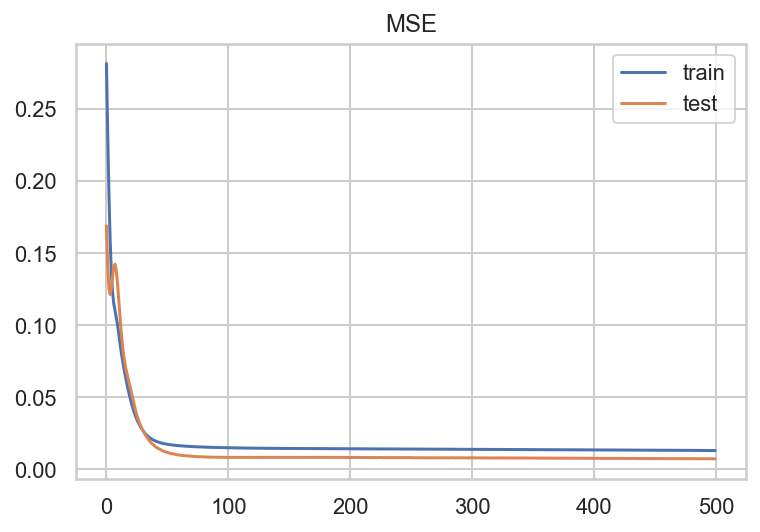

In [18]:
#1 without D
# X, Y, Split
X, Y = dataset_without_d_scaled[:, :-1], dataset_without_d_scaled[:, -1]
X_train = X[:round(len(X)*0.7)]
X_test = X[round(len(X)*0.7):]
Y_train = Y[:round(len(Y)*0.7)]
Y_test = Y[round(len(Y)*0.7):]



# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, random_state=11)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
# Build Model
n_input = Input(shape=(X_train.shape[1],))
H = Dense(8, activation='tanh')(n_input)
H = Dense(5, activation='tanh')(H)

n_output = Dense(1, activation='tanh')(H)
mlp_model = Model(n_input, n_output)
mlp_model.summary()
mlp_model.compile(loss='mse', optimizer='adam', metrics=['acc'])
# Fitting
history_mlp_model_1 = mlp_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=500, batch_size=4096, verbose=2)
# Visualize Curve
plot_history(mlp_model, mode='loss', title='MSE')

(14645, 12) (14645,)
(6277, 12) (6277,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 12)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 45        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 6         
Total params: 155
Trainable params: 155
Non-trainable params: 0
_________________________________________________________________
Train on 14645 samples, validate on 6277 samples
Epoch 1/500
 - 1s - loss: 0.3664 - acc: 0.2091 - val_loss: 0.2897 - val_acc: 0.3964
Epoch 2/500
 - 0s - loss: 0.3112 - acc: 0.3603 - val_loss: 0.2331 - val_acc: 0.6549
Epoch 3/500
 - 0s -

Epoch 87/500
 - 0s - loss: 0.0153 - acc: 0.9564 - val_loss: 0.0131 - val_acc: 0.9788
Epoch 88/500
 - 0s - loss: 0.0153 - acc: 0.9564 - val_loss: 0.0130 - val_acc: 0.9788
Epoch 89/500
 - 0s - loss: 0.0153 - acc: 0.9564 - val_loss: 0.0130 - val_acc: 0.9788
Epoch 90/500
 - 0s - loss: 0.0153 - acc: 0.9564 - val_loss: 0.0129 - val_acc: 0.9788
Epoch 91/500
 - 0s - loss: 0.0152 - acc: 0.9564 - val_loss: 0.0129 - val_acc: 0.9788
Epoch 92/500
 - 0s - loss: 0.0152 - acc: 0.9564 - val_loss: 0.0128 - val_acc: 0.9788
Epoch 93/500
 - 0s - loss: 0.0152 - acc: 0.9564 - val_loss: 0.0127 - val_acc: 0.9788
Epoch 94/500
 - 0s - loss: 0.0152 - acc: 0.9564 - val_loss: 0.0126 - val_acc: 0.9788
Epoch 95/500
 - 0s - loss: 0.0151 - acc: 0.9564 - val_loss: 0.0126 - val_acc: 0.9788
Epoch 96/500
 - 0s - loss: 0.0151 - acc: 0.9564 - val_loss: 0.0126 - val_acc: 0.9788
Epoch 97/500
 - 0s - loss: 0.0151 - acc: 0.9564 - val_loss: 0.0125 - val_acc: 0.9788
Epoch 98/500
 - 0s - loss: 0.0151 - acc: 0.9564 - val_loss: 0.012

Epoch 183/500
 - 0s - loss: 0.0143 - acc: 0.9564 - val_loss: 0.0095 - val_acc: 0.9788
Epoch 184/500
 - 0s - loss: 0.0143 - acc: 0.9564 - val_loss: 0.0095 - val_acc: 0.9788
Epoch 185/500
 - 0s - loss: 0.0143 - acc: 0.9564 - val_loss: 0.0095 - val_acc: 0.9788
Epoch 186/500
 - 0s - loss: 0.0143 - acc: 0.9564 - val_loss: 0.0095 - val_acc: 0.9788
Epoch 187/500
 - 0s - loss: 0.0143 - acc: 0.9564 - val_loss: 0.0094 - val_acc: 0.9788
Epoch 188/500
 - 0s - loss: 0.0143 - acc: 0.9564 - val_loss: 0.0094 - val_acc: 0.9788
Epoch 189/500
 - 0s - loss: 0.0143 - acc: 0.9564 - val_loss: 0.0094 - val_acc: 0.9788
Epoch 190/500
 - 0s - loss: 0.0143 - acc: 0.9564 - val_loss: 0.0094 - val_acc: 0.9788
Epoch 191/500
 - 0s - loss: 0.0142 - acc: 0.9564 - val_loss: 0.0094 - val_acc: 0.9788
Epoch 192/500
 - 0s - loss: 0.0142 - acc: 0.9564 - val_loss: 0.0093 - val_acc: 0.9788
Epoch 193/500
 - 0s - loss: 0.0142 - acc: 0.9564 - val_loss: 0.0093 - val_acc: 0.9788
Epoch 194/500
 - 0s - loss: 0.0142 - acc: 0.9564 - val

Epoch 279/500
 - 0s - loss: 0.0140 - acc: 0.9564 - val_loss: 0.0086 - val_acc: 0.9788
Epoch 280/500
 - 0s - loss: 0.0140 - acc: 0.9564 - val_loss: 0.0086 - val_acc: 0.9788
Epoch 281/500
 - 0s - loss: 0.0140 - acc: 0.9564 - val_loss: 0.0086 - val_acc: 0.9788
Epoch 282/500
 - 0s - loss: 0.0140 - acc: 0.9564 - val_loss: 0.0086 - val_acc: 0.9788
Epoch 283/500
 - 0s - loss: 0.0140 - acc: 0.9564 - val_loss: 0.0086 - val_acc: 0.9788
Epoch 284/500
 - 0s - loss: 0.0140 - acc: 0.9564 - val_loss: 0.0086 - val_acc: 0.9788
Epoch 285/500
 - 0s - loss: 0.0140 - acc: 0.9564 - val_loss: 0.0086 - val_acc: 0.9788
Epoch 286/500
 - 0s - loss: 0.0140 - acc: 0.9564 - val_loss: 0.0086 - val_acc: 0.9788
Epoch 287/500
 - 0s - loss: 0.0140 - acc: 0.9564 - val_loss: 0.0086 - val_acc: 0.9788
Epoch 288/500
 - 0s - loss: 0.0140 - acc: 0.9564 - val_loss: 0.0086 - val_acc: 0.9788
Epoch 289/500
 - 0s - loss: 0.0140 - acc: 0.9564 - val_loss: 0.0086 - val_acc: 0.9788
Epoch 290/500
 - 0s - loss: 0.0140 - acc: 0.9564 - val

Epoch 375/500
 - 0s - loss: 0.0138 - acc: 0.9564 - val_loss: 0.0083 - val_acc: 0.9788
Epoch 376/500
 - 0s - loss: 0.0138 - acc: 0.9564 - val_loss: 0.0083 - val_acc: 0.9788
Epoch 377/500
 - 0s - loss: 0.0138 - acc: 0.9564 - val_loss: 0.0083 - val_acc: 0.9788
Epoch 378/500
 - 0s - loss: 0.0138 - acc: 0.9564 - val_loss: 0.0083 - val_acc: 0.9788
Epoch 379/500
 - 0s - loss: 0.0138 - acc: 0.9564 - val_loss: 0.0083 - val_acc: 0.9788
Epoch 380/500
 - 0s - loss: 0.0138 - acc: 0.9564 - val_loss: 0.0083 - val_acc: 0.9788
Epoch 381/500
 - 0s - loss: 0.0138 - acc: 0.9564 - val_loss: 0.0083 - val_acc: 0.9788
Epoch 382/500
 - 0s - loss: 0.0138 - acc: 0.9564 - val_loss: 0.0083 - val_acc: 0.9788
Epoch 383/500
 - 0s - loss: 0.0138 - acc: 0.9564 - val_loss: 0.0083 - val_acc: 0.9788
Epoch 384/500
 - 0s - loss: 0.0138 - acc: 0.9564 - val_loss: 0.0083 - val_acc: 0.9788
Epoch 385/500
 - 0s - loss: 0.0138 - acc: 0.9564 - val_loss: 0.0083 - val_acc: 0.9788
Epoch 386/500
 - 0s - loss: 0.0138 - acc: 0.9564 - val

Epoch 471/500
 - 0s - loss: 0.0136 - acc: 0.9564 - val_loss: 0.0082 - val_acc: 0.9788
Epoch 472/500
 - 0s - loss: 0.0136 - acc: 0.9564 - val_loss: 0.0082 - val_acc: 0.9788
Epoch 473/500
 - 0s - loss: 0.0135 - acc: 0.9564 - val_loss: 0.0082 - val_acc: 0.9788
Epoch 474/500
 - 0s - loss: 0.0135 - acc: 0.9564 - val_loss: 0.0082 - val_acc: 0.9788
Epoch 475/500
 - 0s - loss: 0.0135 - acc: 0.9564 - val_loss: 0.0082 - val_acc: 0.9788
Epoch 476/500
 - 0s - loss: 0.0135 - acc: 0.9564 - val_loss: 0.0082 - val_acc: 0.9788
Epoch 477/500
 - 0s - loss: 0.0135 - acc: 0.9564 - val_loss: 0.0082 - val_acc: 0.9788
Epoch 478/500
 - 0s - loss: 0.0135 - acc: 0.9564 - val_loss: 0.0082 - val_acc: 0.9788
Epoch 479/500
 - 0s - loss: 0.0135 - acc: 0.9564 - val_loss: 0.0082 - val_acc: 0.9788
Epoch 480/500
 - 0s - loss: 0.0135 - acc: 0.9564 - val_loss: 0.0082 - val_acc: 0.9788
Epoch 481/500
 - 0s - loss: 0.0135 - acc: 0.9564 - val_loss: 0.0082 - val_acc: 0.9788
Epoch 482/500
 - 0s - loss: 0.0135 - acc: 0.9564 - val

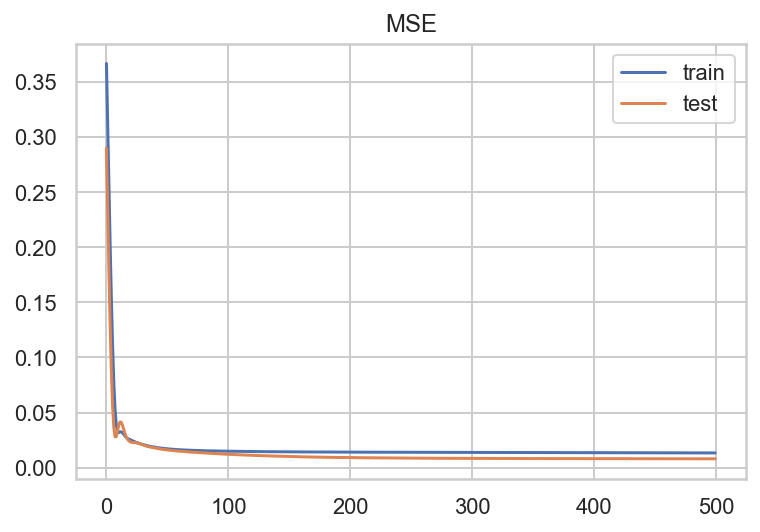

In [19]:
#1 with D
# X, Y, Split
X, Y = dataset_with_d_scaled[:, :-1], dataset_with_d_scaled[:, -1]

X_train = X[:round(len(X)*0.7)]
X_test = X[round(len(X)*0.7):]
Y_train = Y[:round(len(Y)*0.7)]
Y_test = Y[round(len(Y)*0.7):]
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, random_state=11)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
# Build Model
n_input = Input(shape=(X_train.shape[1],))
H = Dense(8, activation='tanh')(n_input)
H = Dense(5, activation='tanh')(H)

n_output = Dense(1, activation='tanh')(H)
mlp_model = Model(n_input, n_output)
mlp_model.summary()
mlp_model.compile(loss='mse', optimizer='adam', metrics=['acc'])
# Fitting
history_mlp_model_1 = mlp_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=500, batch_size=4096, verbose=2)
# Visualize Curve
plot_history(mlp_model, mode='loss', title='MSE')